# GoogLeNet 识别手写数字
2014年，获得ImageNet图像分类竞赛的冠军是GoogLeNet，其解决了一个重要问题：滤波器超参数选择困难，如何能够自动找到最佳的情况。 GoogLeNet 并没有打错，其中的 L 大写是为了致敬 LeNet 。

GoogLeNet 在网络中引入了一个小网络——Inception 块，Inception 不能被直接翻译，不过这个单词有“开始”“植入”的意思，《盗梦空间》英文名就是这个。

Inception 的引入像是给每一层的神经元提供了不用的处理方法和路线，最后再进行汇总。谷歌发布的论文 [Going deeper with convolutions](https://arxiv.org/abs/1409.4842) 有介绍。

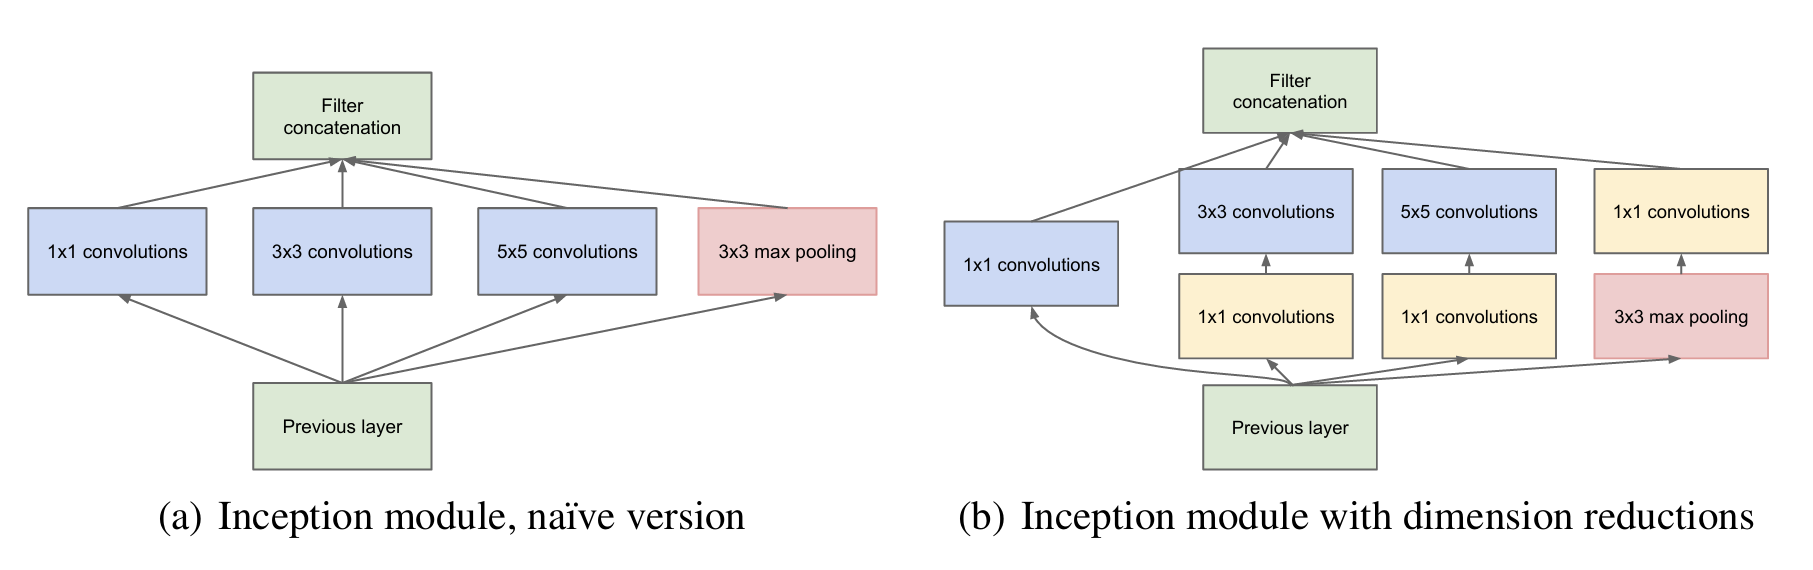

In [1]:
from IPython.display import Image

Image(filename='./images/GoogLeNet Inception.png')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [9]:
transform = transforms.Compose(  # 将多个图像变换操作组合在一起
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# 下载训练集
train_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=transform
)

# 批次加载器
train_loader = DataLoader(train_data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_data, shuffle=False, batch_size=256)

In [4]:
class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=1),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=1),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Conv2d(in_channels=in_channels, out_channels=24, kernel_size=1)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        return torch.cat((out1, out2, out3, out4), dim=1)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Inception(in_channels=10),
            nn.Conv2d(in_channels=88, out_channels=20, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Inception(in_channels=20),
            nn.Flatten(),
            nn.Linear(in_features=1408, out_features=10),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
X = torch.rand(size=(1, 1, 28, 28))
for layer in Net().net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 10, 24, 24])
ReLU output shape: 	 torch.Size([1, 10, 24, 24])
MaxPool2d output shape: 	 torch.Size([1, 10, 12, 12])
Inception output shape: 	 torch.Size([1, 88, 12, 12])
Conv2d output shape: 	 torch.Size([1, 20, 8, 8])
ReLU output shape: 	 torch.Size([1, 20, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 20, 4, 4])
Inception output shape: 	 torch.Size([1, 88, 4, 4])
Flatten output shape: 	 torch.Size([1, 1408])
Linear output shape: 	 torch.Size([1, 10])


In [7]:
net = Net().to('cuda')

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

59.748138785362244
15.049201747402549
11.062608609907329
9.205685402499512
7.177769709844142
6.679749995470047
5.750127436127514
5.0988464473048225
5.13810044049751
3.621826534741558


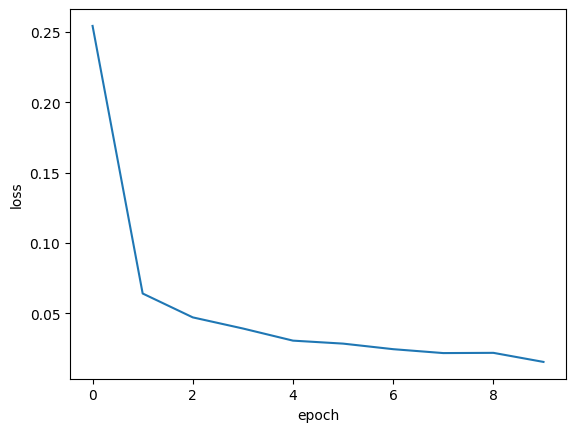

In [10]:
epochs = 10
losses = []

for epoch in range(epochs):
    avg_loss = 0
    times = 0

    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        times += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(avg_loss)
    losses.append(avg_loss / times)

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [11]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():
    for (x, y) in test_loader:
        # 获取小批次的x与y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = net(x)
        # 该局部关闭梯度计算功能
        # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum((predicted == y))
        total += y.size(0)

print(f'测试集精准度: {100 * correct/total} %')

测试集精准度: 99.0199966430664 %


In [15]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=48, height=48, brush_size=6)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=48, height=48)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((28, 28)),  # 调整大小为 28 * 28
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)